In [1]:
# source venv310-totem/bin/activate

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path


In [3]:
# config
project_root = Path("/Users/jan/Documents/working papers/project 1").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_CSV = str(Path("/Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv"))
OUT_DIR = project_root / "models"
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PRED_CSV = OUT_DIR / "totem_zeroshot_btc_preds.csv"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96  # keep consistent with other notebooks (forecast horizon)



print("Python:", sys.version)
print("DATA_CSV:", DATA_CSV)
print("OUT_PRED_CSV:", OUT_PRED_CSV)

Python: 3.10.18 (main, Jun  3 2025, 18:23:41) [Clang 17.0.0 (clang-1700.0.13.3)]
DATA_CSV: /Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv
OUT_PRED_CSV: /Users/jan/Documents/working papers/project 1/models/totem_zeroshot_btc_preds.csv


In [4]:
# data loading and preprocessing
df = pd.read_csv(DATA_CSV)
if 'timestamp' not in df.columns or 'close' not in df.columns:
    raise ValueError("Expected columns: 'timestamp', 'close'.")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').set_index('timestamp')
df = df[['close']].dropna()

# optional normalization like in sister notebooks (keep minimal here)
y = df['close'].to_numpy(dtype=float)
y_mean = float(np.mean(y))
y_std = float(np.std(y)) if np.std(y) > 0 else 1.0
y_norm = (y - y_mean) / y_std
len(df), y_mean, y_std

(10000, 10025.280273, 2450.2658503075736)

In [5]:
# === TOTEM: define paths (repo already cloned; deps installed in venv) ===
from pathlib import Path

TOTEM_DIR        = project_root / "external" / "TOTEM"
TOKENIZER_DIR    = Path.home() / "models" / "totem"            # generalist tokenizer lives here
PROCESSED_DIR    = project_root / "data" / "totem_zero_shot" / "btc"
PRED_OUTPUT_DIR  = project_root / "outputs" / "totem" / "btc"
OUT_PRED_CSV     = project_root / "models" / "totem_zeroshot_btc_preds.csv"

for p in [TOKENIZER_DIR, PROCESSED_DIR, PRED_OUTPUT_DIR, OUT_PRED_CSV.parent]:
    p.mkdir(parents=True, exist_ok=True)


TOKENIZER_CKPT = Path.home() / "models" / "totem" / "final_model.pth"
assert TOKENIZER_CKPT.exists(), f"Missing checkpoint: {TOKENIZER_CKPT}"
print("TOKENIZER_CKPT :", TOKENIZER_CKPT)

print("TOTEM_DIR      :", TOTEM_DIR)
print("DATA_CSV       :", DATA_CSV)
print("TOKENIZER_DIR  :", TOKENIZER_DIR)
print("PROCESSED_DIR  :", PROCESSED_DIR)
print("PRED_OUTPUT_DIR:", PRED_OUTPUT_DIR)
print("OUT_PRED_CSV   :", OUT_PRED_CSV)
print("CONTEXT_LENGTH :", CONTEXT_LENGTH, "  PREDICTION_LENGTH:", PREDICTION_LENGTH)

TOKENIZER_CKPT : /Users/jan/models/totem/final_model.pth
TOTEM_DIR      : /Users/jan/Documents/working papers/project 1/external/TOTEM
DATA_CSV       : /Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv
TOKENIZER_DIR  : /Users/jan/models/totem
PROCESSED_DIR  : /Users/jan/Documents/working papers/project 1/data/totem_zero_shot/btc
PRED_OUTPUT_DIR: /Users/jan/Documents/working papers/project 1/outputs/totem/btc
OUT_PRED_CSV   : /Users/jan/Documents/working papers/project 1/models/totem_zeroshot_btc_preds.csv
CONTEXT_LENGTH : 512   PREDICTION_LENGTH: 96


In [6]:
F = None
try:
    import torch, math
    ckpt = torch.load(TOKENIZER_CKPT, map_location="cpu")
    enc_cfg = ckpt.get("config", {}).get("encoder", {})
    strides = enc_cfg.get("strides") or enc_cfg.get("downsample") or []
    if isinstance(strides, (list, tuple)) and strides:
        F = int(math.prod([int(s) for s in strides]))
except Exception as e:
    print(f"[warn] couldn’t infer tokenizer stride F: {e}")

if F:
    if CONTEXT_LENGTH % F != 0:
        raise ValueError(f"CONTEXT_LENGTH={CONTEXT_LENGTH} must be divisible by tokenizer stride F={F}.")
    else:
        print(f"Tokenizer stride F={F} OK for CONTEXT_LENGTH={CONTEXT_LENGTH}.")
else:
    print("[warn] Tokenizer stride F unknown; proceeding.")

[warn] couldn’t infer tokenizer stride F: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL lib.models.vqvae.vqvae was not an allowed global by default. Please use `torch.serialization.add_safe_globals([lib.models.vqvae.vqvae])` or the `torch.serialization.safe_globals([lib.models.vqvae.vqvae])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more

In [7]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(DATA_CSV, parse_dates=["timestamp"]).sort_values("timestamp")
vals = df["close"].astype(float).tolist()
N = len(vals)
start_ts = df["timestamp"].iloc[0].strftime("%Y-%m-%d %H-%M-%S")  # ASCII hyphens

def _freq_word(ts):
    f = pd.infer_freq(ts) or ""
    f = f.upper()
    if f in ("H","1H","60T"): return "hourly"
    if f in ("T","1T"):       return "minutely"
    if f in ("S","1S"):       return "seconds"
    if f in ("D","1D"):       return "daily"
    if f in ("W","1W"):       return "weekly"
    if f in ("M","1M"):       return "monthly"
    return "hourly"

freq_word = _freq_word(df["timestamp"])

def make_tsf_text(dataset_name: str) -> str:
    header = [
        f"@datasetName {dataset_name}",
        "@missing false",
        "@equallength true",
        f"@serieslength {N}",
        f"@frequency {freq_word}",
        f"@horizon {int(PREDICTION_LENGTH)}",
        "@attribute start_timestamp date",
        "@attribute series_value real",
        "@data",
    ]
    data_line = f"{start_ts}:" + ",".join(f"{v:.12g}" for v in vals)
    # join with LF and ensure no leading spaces
    return "\n".join(s.strip() for s in header + [data_line]) + "\n"

TSF_ROOT = PROCESSED_DIR / "btc_tsf"
TSF_ROOT.mkdir(parents=True, exist_ok=True)
(BTC_TSF := TSF_ROOT / "btc.tsf").write_text(make_tsf_text("btc"), encoding="utf-8")
(SAU_TSF := TSF_ROOT / "saugeen.tsf").write_text(make_tsf_text("saugeen"), encoding="utf-8")

print("=== saugeen.tsf head ===")
print("\n".join(SAU_TSF.read_text(encoding="utf-8").splitlines()[:12]))

=== saugeen.tsf head ===
@datasetName saugeen
@missing false
@equallength true
@serieslength 10000
@frequency hourly
@horizon 96
@attribute start_timestamp date
@attribute series_value real
@data
2018-01-01 00-00-00:13999.14,13886.89,13920,13949.61,14029.91,14048,14172.63,14111.28,14033.38,13981.05,13996.9,13977.47,13977.04,13950,13969.5,13937.95,13937.64,13930.01,13890.95,13880,13715,13726.16,13664,13668.52,13600,13651,13499.98,13355,13450.85,13346.1,13400,13429.08,13516.99,13602.71,13580.81,13481.73,13430.55,13483.82,13610.36,13697,13533.98,13548.36,13530.95,13569.99,13542.97,13687.82,13774.51,13875.82,13840.84,13815.94,13675.49,13660.56,13699,13647.39,13484.98,13499.9,13590.48,13525.22,13560,13612,13555.71,13514.65,13585.53,13548.46,13255.63,13150.62,13244.52,13303.35,13346.47,13275,13360,13250.35,13218.08,13127.13,13150,13118.56,12949.03,12999.99,13002,13229.56,13239.9,13340.11,13247,13276.78,13273.66,13127.45,13158.21,13051.36,13156.1,13232.07,13184.32,13085.99,13155.46,13308.3,13

In [8]:
from pathlib import Path
import re

TSF_ROOT = PROCESSED_DIR / "btc_tsf"
for name in ("btc.tsf", "saugeen.tsf"):
    p = TSF_ROOT / name
    txt = p.read_text(encoding="utf-8", errors="replace")

    # Normalize line endings
    txt = txt.replace("\r\n", "\n").replace("\r", "\n")
    # Replace en/em-dash with ASCII hyphen
    txt = txt.replace("–", "-").replace("—", "-")

    # Remove UTF-8 BOM 
    if txt and txt[0] == "\ufeff":
        txt = txt[1:]

    #strip leading/trailing spaces per line 
    lines = [ln.strip() for ln in txt.split("\n")]

    # assert required header lines exist (after stripping)
    head = "\n".join(lines[:12])
    assert "@attribute start_timestamp date" in head, "missing 'start_timestamp date' attribute"
    assert "@attribute series_value real"   in head, "missing 'series_value real' attribute"
    assert "@data"                          in head, "missing '@data' line"

    # Write back with LF and trailing newline, UTF-8 (no BOM)
    p.write_text("\n".join(lines) + "\n", encoding="utf-8")

print("Sanitized btc.tsf and saugeen.tsf")

Sanitized btc.tsf and saugeen.tsf


In [9]:

from pathlib import Path
import re

hits = []
for p in (TOTEM_DIR).rglob("*.py"):
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        continue

    if ("argparse" in txt) and (re.search(r"forecast|pred_len|horizon", txt, re.I)) and (re.search(r"tokenizer|vqvae|codebook", txt, re.I)):
        hits.append(p)

print("Candidate scripts:")
for h in sorted(hits):
    print("-", h)

Candidate scripts:
- /Users/jan/Documents/working papers/project 1/external/TOTEM/anomaly_detection/detect_anomaly.py
- /Users/jan/Documents/working papers/project 1/external/TOTEM/forecasting/extract_forecasting_data.py
- /Users/jan/Documents/working papers/project 1/external/TOTEM/imputation/imputation_performance.py


In [10]:
import subprocess, sys
for py in hits:
    print("\n==== HELP for", py.name, "====")
    r = subprocess.run([sys.executable, str(py), "-h"],
                       cwd=str(py.parent), capture_output=True, text=True)
    print((r.stdout or r.stderr)[:2000])


==== HELP for detect_anomaly.py ====
usage: detect_anomaly.py [-h] --dataset DATASET --trained_vqvae_model_path
                         TRAINED_VQVAE_MODEL_PATH --compression_factor
                         COMPRESSION_FACTOR [--use_gpu USE_GPU] [--gpu GPU]
                         [--use_multi_gpu] [--base_path BASE_PATH]
                         [--labels_path LABELS_PATH]
                         [--anomaly_ratio ANOMALY_RATIO] [--seq_len SEQ_LEN]
                         [--num_vars NUM_VARS]

Autoformer & Transformer family for Time Series Forecasting

options:
  -h, --help            show this help message and exit
  --dataset DATASET
  --trained_vqvae_model_path TRAINED_VQVAE_MODEL_PATH
  --compression_factor COMPRESSION_FACTOR
                        compression_factor
  --use_gpu USE_GPU     use gpu
  --gpu GPU             gpu
  --use_multi_gpu       use multiple gpus
  --base_path BASE_PATH
                        which data to perform oracle on
  --labels_path LABELS_PATH


In [ ]:
from pathlib import Path
import re, subprocess, sys

cands = []
for p in (TOTEM_DIR / "forecasting").rglob("*.py"):
    try:
        txt = p.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        continue
    if ("argparse" in txt and
        re.search(r"(trained_vqvae_model_path|tokenizer|vqvae|codebook)", txt, re.I) and
        re.search(r"(forecast|pred_len|horizon)", txt, re.I)):
        cands.append(p)

print("Candidates:")
for i, p in enumerate(sorted(cands), 1):
    print(f"{i:2d}.", p)



for p in cands:
    print("\n==== HELP for", p.relative_to(TOTEM_DIR), "====")
    r = subprocess.run([sys.executable, str(p), "-h"],
                       cwd=str(p.parent), capture_output=True, text=True)
    print((r.stdout or r.stderr)[:3000])

Candidates:
 1. /Users/jan/Documents/working papers/project 1/external/TOTEM/forecasting/extract_forecasting_data.py

==== HELP for forecasting/extract_forecasting_data.py ====
usage: extract_forecasting_data.py [-h] [--random_seed RANDOM_SEED] --data
                                   DATA [--root_path ROOT_PATH]
                                   [--data_path DATA_PATH]
                                   [--features FEATURES] [--target TARGET]
                                   [--freq FREQ] [--seq_len SEQ_LEN]
                                   [--label_len LABEL_LEN]
                                   [--pred_len PRED_LEN] [--enc_in ENC_IN]
                                   [--embed EMBED] [--num_workers NUM_WORKERS]
                                   [--batch_size BATCH_SIZE]
                                   [--use_gpu USE_GPU] [--gpu GPU]
                                   [--use_multi_gpu] [--devices DEVICES]
                                   [--test_flop] [--save_path SAVE_

In [ ]:
# === Write + run TOTEM scripts with explicit flags and your current interpreter ===
import os, stat, subprocess, sys
from pathlib import Path

proc_py = TOTEM_DIR / "process_zero_shot_data" / "process_saugeen_sun_births.py"
fore_py = TOTEM_DIR / "process_zero_shot_data" / "forecasting_saugeen_sun_births.py"
assert proc_py.exists() and fore_py.exists(), "TOTEM processing/forecasting scripts not found in your clone."

btc_process = TOTEM_DIR / "process_zero_shot_data" / "scripts" / "btc.sh"
btc_fore    = TOTEM_DIR / "forecasting"            / "scripts" / "btc.sh"
btc_process.parent.mkdir(parents=True, exist_ok=True)
btc_fore.parent.mkdir(parents=True, exist_ok=True)

def _write_exec(path: Path, text: str):
    text = text.replace("\r\n","\n").replace("\r","\n")
    path.write_text(text, encoding="utf-8")
    os.chmod(path, os.stat(path).st_mode | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)

def _script_help(pyfile: Path) -> str:
    env = dict(os.environ)
    env["PYTHON"] = sys.executable
    r = subprocess.run(
        [sys.executable, str(pyfile), "-h"],
        cwd=str(pyfile.parent),
        capture_output=True, text=True, env=env
    )
    return (r.stdout + "\n" + r.stderr)

def _has(help_text: str, flag: str) -> bool:
    # cheap substring check for a long-flag
    return f"--{flag}" in help_text

btc_process_text = f"""#!/usr/bin/env bash
set -euo pipefail
PY="${{PYTHON:-python}}"
TSF="{str(SAU_TSF)}"
SAVE="{str(PROCESSED_DIR / 'data')}"
echo "[PROCESS] $TSF -> $SAVE"
"$PY" "{proc_py}" --base_path "$TSF" --save_path "$SAVE"
echo "[PROCESS] Done."
"""
_write_exec(btc_process, btc_process_text)

# 2) FORECAST: probe available flags, then assemble the command
help_f = _script_help(fore_py)

# tokenizer flag
tok_flag = None
for cand in ("tokenizer_ckpt","ckpt_path","ckpt"):
    if _has(help_f, cand):
        tok_flag = f"--{cand} {shlex.quote(str(TOKENIZER_CKPT))}"
        break

# context length
ctx_flag = None
for cand in ("context_len","context_length","seq_len","seq_length","lookback"):
    if _has(help_f, cand):
        ctx_flag = f"--{cand} {int(CONTEXT_LENGTH)}"
        break

# horizon / pred length
h_flag = None
for cand in ("pred_len","pred_length","horizon","H"):
    if _has(help_f, cand):
        h_flag = f"--{cand} {int(PREDICTION_LENGTH)}"
        break

# encoder & positional emb toggles (if any)
enc_flag = "--use_transformer_encoder" if _has(help_f, "use_transformer_encoder") else ""
pos_flag = "--positional_emb"          if _has(help_f, "positional_emb")          else ""

pieces = [
    f'"$PY" "{fore_py}"',
    f'--base_path "{str(SAU_TSF)}"',
    f'--save_path "{str(PRED_OUTPUT_DIR)}"',
    tok_flag or "",
    ctx_flag or "",
    h_flag or "",
    enc_flag,
    pos_flag,
]
cmd_line = " ".join([p for p in pieces if p])

btc_fore_text = f"""#!/usr/bin/env bash
set -euo pipefail
PY="${{PYTHON:-python}}"
echo "[FORECAST] Running with autodetected flags:"
echo "{cmd_line}"
{cmd_line}
echo "[FORECAST] Done."
"""
_write_exec(btc_fore, btc_fore_text)

def _run_bash(script: Path, cwd: Path):
    print("Running:", script)
    env = dict(os.environ)
    env["PYTHON"] = sys.executable  # ensure same interpreter as notebook
    r = subprocess.run(["bash", str(script)], cwd=str(cwd), capture_output=True, text=True, env=env)
    print("---- STDOUT (tail) ----"); print(r.stdout[-2000:])
    if r.returncode != 0:
        print("---- STDERR (full) ----"); print(r.stderr)
        raise RuntimeError(f"Script failed: {script} (exit {r.returncode})")
    return r

_run_bash(btc_process, TOTEM_DIR)
_run_bash(btc_fore,    TOTEM_DIR)
print("Finished process+forecast.")

Running: /Users/jan/Documents/working papers/project 1/external/TOTEM/process_zero_shot_data/scripts/btc.sh
---- STDOUT (tail) ----
[PROCESS] /Users/jan/Documents/working papers/project 1/data/totem_zero_shot/btc/btc_tsf/saugeen.tsf -> /Users/jan/Documents/working papers/project 1/data/totem_zero_shot/btc/data

---- STDERR (full) ----
/Users/jan/Documents/working papers/project 1/external/TOTEM/process_zero_shot_data/process_saugeen_sun_births.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.util import strtobool
Traceback (most recent call last):
  File "/Users/jan/Documents/working papers/project 1/external/TOTEM/process_zero_shot_data/process_saugeen_sun_births.py", line 254, in <module>
    main(args)
  File "/Users/jan/Documents/working papers/project 1/external/TOTEM/process_zero_shot_data/process_saugeen_sun_births.py", line 192, in main
    df, frequen

RuntimeError: Script failed: /Users/jan/Documents/working papers/project 1/external/TOTEM/process_zero_shot_data/scripts/btc.sh (exit 1)

In [ ]:
# === Adapt repo outputs to canonical schema and save ===
import numpy as np, pandas as pd
from pathlib import Path

# Original BTC for timestamps/true values
df_price = pd.read_csv(DATA_CSV, parse_dates=["timestamp"]).sort_values("timestamp")
ts_all   = df_price["timestamp"].to_numpy()
close    = df_price["close"].to_numpy(float)

pred_df = None

# Prefer *.npz with explicit indices (common case)
for fp in sorted(Path(PRED_OUTPUT_DIR).rglob("*.npz")):
    raw = np.load(fp)
    keys = set(raw.files)
    if {"start_idx","y_pred_h1"} <= keys:
        t_idx = raw["start_idx"].astype(int); yph1 = raw["y_pred_h1"].astype(float)
    elif {"t_idx","pred_h1"} <= keys:
        t_idx = raw["t_idx"].astype(int);     yph1 = raw["pred_h1"].astype(float)
    else:
        continue
    t1 = t_idx + 1
    good = (t1 >= 1) & (t1 < len(close)) & (len(yph1) == len(t1))
    t1, yph1 = t1[good], yph1[good]
    pred_df = pd.DataFrame({
        "timestamp": pd.to_datetime(ts_all[t1]),
        "y_true":    close[t1].astype(np.float32),
        "y_pred":    yph1.astype(np.float32),
    })
    break

# Fallback: tidy CSV already written by the repo
if pred_df is None:
    for fp in sorted(Path(PRED_OUTPUT_DIR).rglob("*.csv")):
        tmp = pd.read_csv(fp)
        lc = {c.lower(): c for c in tmp.columns}
        if {"timestamp","y_true","y_pred"} <= set(map(str.lower, tmp.columns)):
            pred_df = tmp.rename(columns={
                lc["timestamp"]:"timestamp",
                lc["y_true"]:"y_true",
                lc["y_pred"]:"y_pred",
            }).sort_values("timestamp")
            pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"])
            break

if pred_df is None:
    raise RuntimeError("No usable predictions found under PRED_OUTPUT_DIR.")

# Guard against lagged outputs
share_prev = (pred_df["y_pred"].round(12) == pred_df["y_true"].shift(1).round(12)).mean()
print("share y_pred equals previous y_true:", f"{share_prev:.3f}")
if share_prev > 0.5:
    raise RuntimeError("Predictions look lagged—ensure forecasting produced true h=1 forecasts and t→t+1 mapping.")

pred_df.to_csv(OUT_PRED_CSV, index=False)
print(f"Saved predictions -> {OUT_PRED_CSV}  rows={len(pred_df)}")

pred_df.tail()

In [ ]:
from utils.metrics import equity_no_tc, equity_with_tc, compute_positions_and_returns

STARTING_CAPITAL = 100000
THRESH = 0.005   
FEE    = 0.001

y_true = pred_df["y_true"].to_numpy(float)
y_pred = pred_df["y_pred"].to_numpy(float)

eq_no  = equity_no_tc(y_true, y_pred, STARTING_CAPITAL, THRESH)
eq_tc, fee, cum_fee = equity_with_tc(y_true, y_pred, STARTING_CAPITAL, THRESH, FEE)
tech   = compute_positions_and_returns(y_true, y_pred, THRESH)


pred_df = pred_df.copy()
pred_df["equity"]      = eq_no.values
pred_df["equity_tc"]   = eq_tc.values
pred_df["fee"]         = fee.values
pred_df["cum_fee"]     = cum_fee.values
pred_df["position"]    = tech["exec_pos"]
pred_df["position_raw"]= tech["pos_raw"]
pred_df["ret"]         = tech["ret"]

print(f"Relative threshold: {THRESH:.4f}")
print(f"Transaction cost rate: {FEE:.4f}")
print(f"Cumulative fees paid: {pred_df['cum_fee'].iloc[-1]:,.2f}")
print(f"Final equity (no cost): {pred_df['equity'].iloc[-1]:,.2f}")
print(f"Final equity (with TC): {pred_df['equity_tc'].iloc[-1]:,.2f}")

Relative threshold: 0.0000
Transaction cost rate: 0.0010
Cumulative fees paid: 0.00
Final equity (no cost): 100,000.00
Final equity (with TC): 100,000.00


(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'TTM zero-shot BTC 1h'}, ylabel='Price'>,
  <Axes: title={'center': 'Equity (with fees) vs B&H'}, xlabel='Time', ylabel='Equity'>))

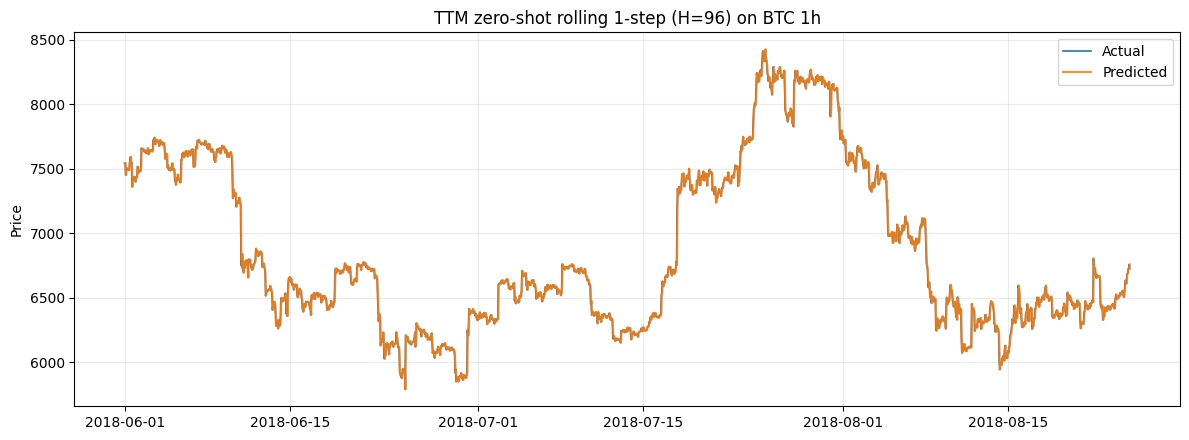

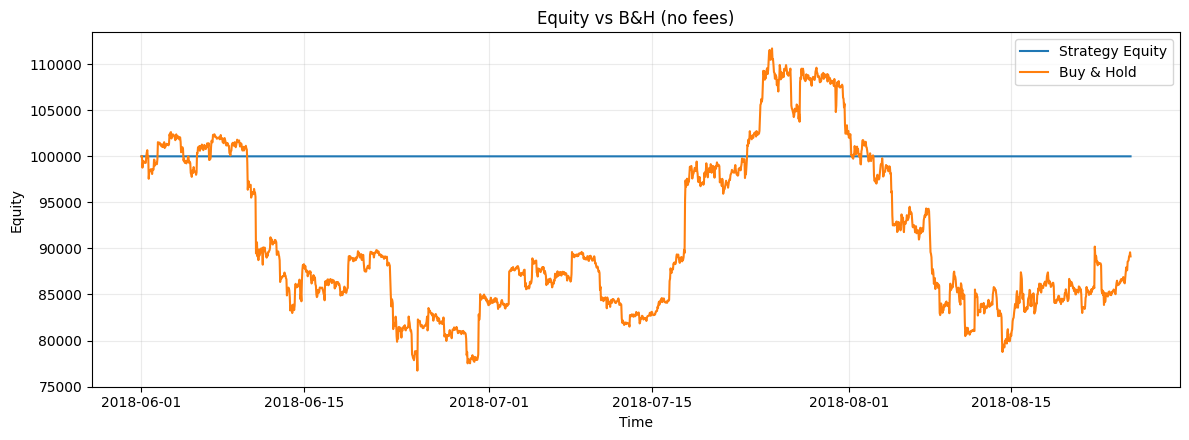

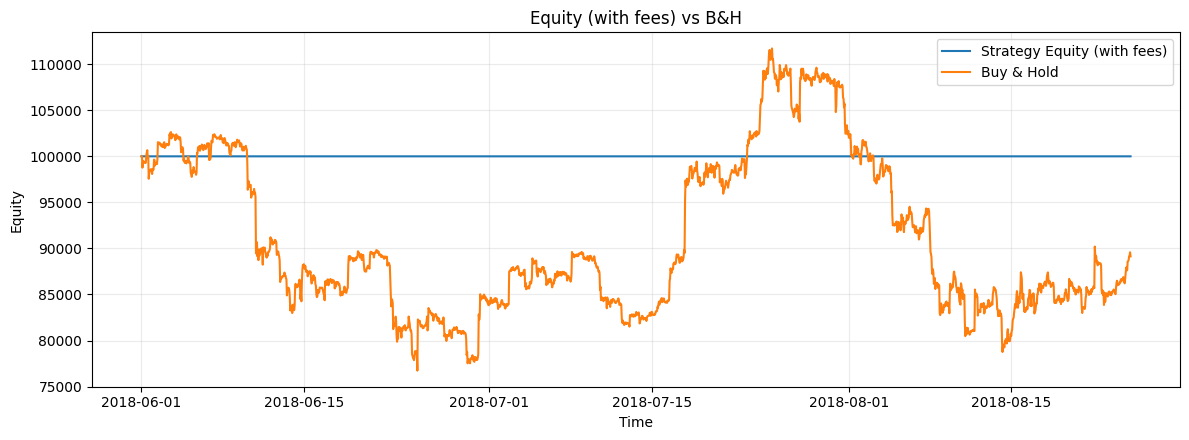

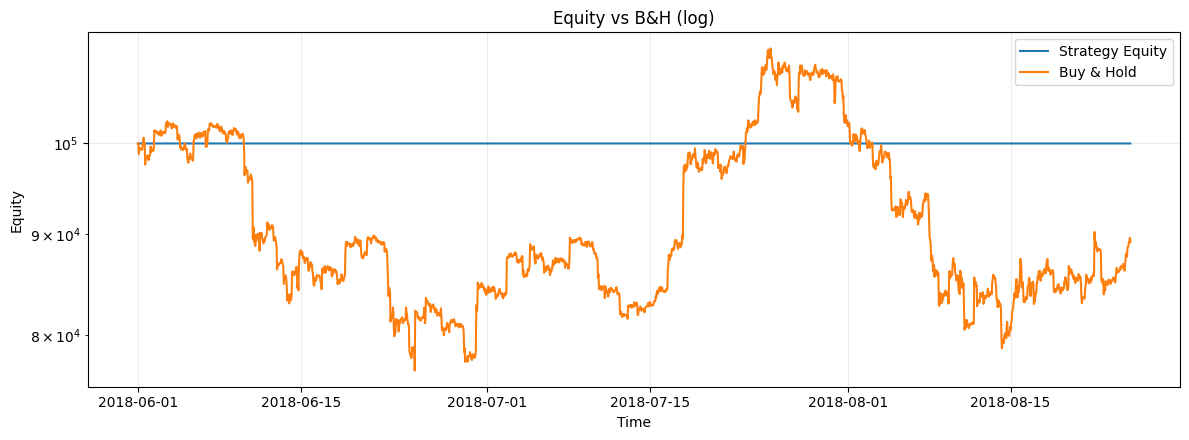

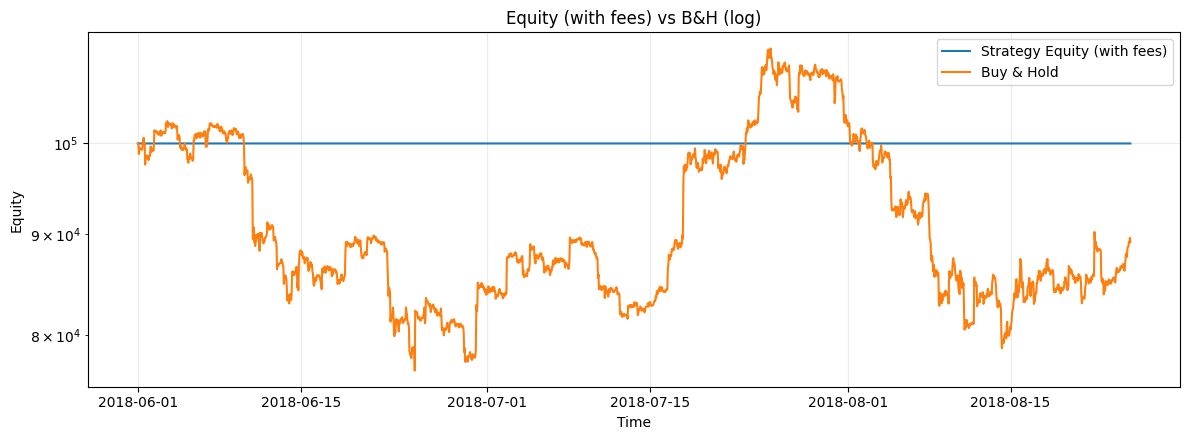

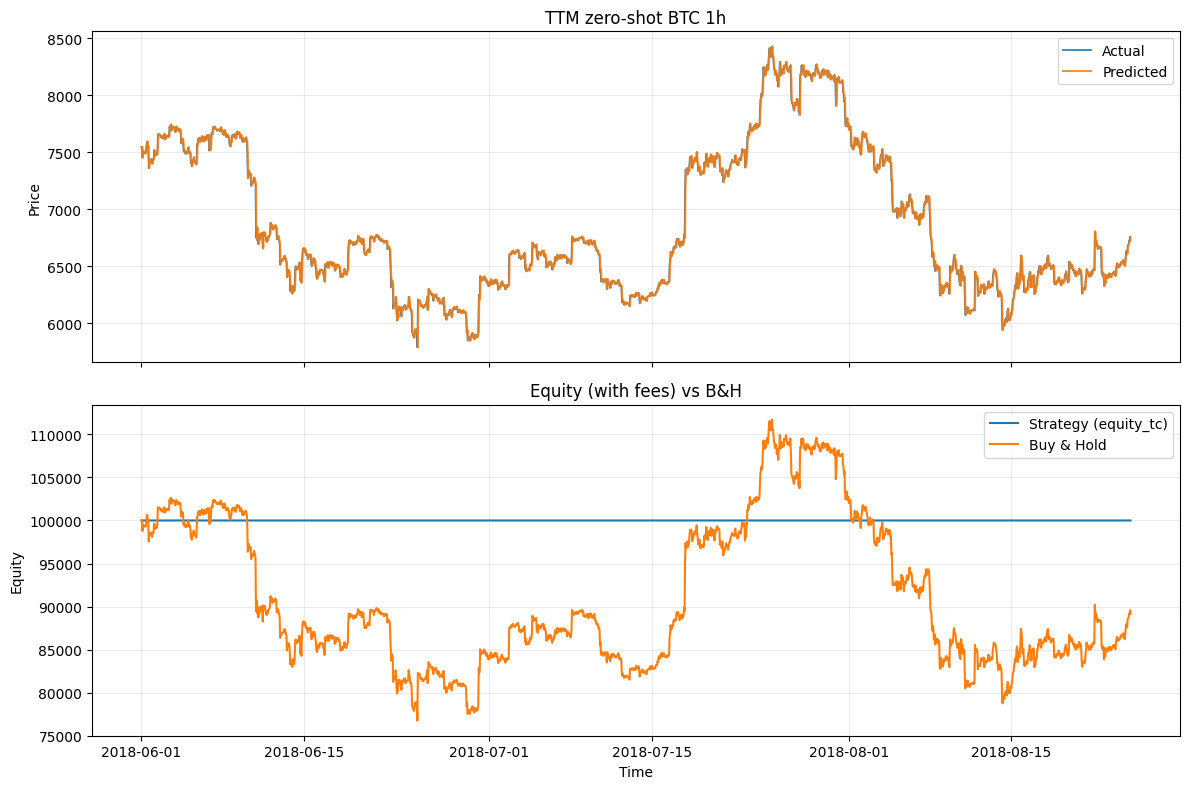

In [ ]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

# 1) Price: actual vs predicted
plot_price_actual_vs_pred(
    pred_df,
    title="TTM zero-shot rolling 1-step (H=96) on BTC 1h"
)

# 2) Equity vs Buy-and-Hold (no fees)
plot_equity_no_tc_vs_bh(
    pred_df,
    title="Equity vs B&H (no fees)"
)

# 3) Equity (with fees) vs Buy-and-Hold
plot_equity_tc_vs_bh(
    pred_df,
    title="Equity (with fees) vs B&H"
)

# 4) Log versions
plot_equity_no_tc_vs_bh_log(pred_df, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(pred_df, title="Equity (with fees) vs B&H (log)")

# 5) Two-panel combo
plot_price_and_equity_panel(
    pred_df,
    equity_col="equity_tc",  # or "equity"
    title_price="TTM zero-shot BTC 1h",
    title_equity="Equity (with fees) vs B&H",
    logy_equity=False,
)